In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('02-insurance-linear-regression-a2')
jovian.set_colab_id('1XKkfFlUB1iI4RNrvWK9V6fVXCKmUGGhi')

In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [3]:
project_name='02-insurance-linear-regression-a2' # will be used by jovian.commit

In [4]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: .\insurance.csv


In [5]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
your_name = "yashsakaria"

In [7]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 0:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [8]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
644,43,male,34.25070,2,no,21627.067290
156,48,male,23.68740,0,yes,24407.227170
15,19,male,23.86200,1,no,2112.822550
432,42,male,26.09300,0,no,6865.181450
20,60,female,34.92485,0,no,15213.173993


In [9]:
dataframe.shape

(1271, 6)

In [10]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


In [11]:
num_cols = dataframe.shape[1]
print(num_cols)

6


In [12]:
input_cols = ['age', 'sex', 'bmi', 'children', 'smoker',]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

In [13]:
dataframe.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
charges     float64
dtype: object

In [14]:
# categorical_cols = [dataframe.select_dtypes(include=['object'])]

categorical_cols = dataframe.columns[dataframe.dtypes == 'object'].tolist()
categorical_cols

['sex', 'smoker']

In [15]:
dataframe

,age,sex,bmi,children,smoker,charges
644,43,male,34.25070,2,no,21627.067290
156,48,male,23.68740,0,yes,24407.227170
15,19,male,23.86200,1,no,2112.822550
432,42,male,26.09300,0,no,6865.181450
20,60,female,34.92485,0,no,15213.173993
...,...,...,...,...,...,...
578,52,male,29.29400,1,no,11183.209500
718,51,female,35.56990,2,no,12475.354445
1208,37,female,24.78835,1,yes,23341.392968
130,59,female,25.70985,0,no,14737.761692


In [16]:
dataframe['charges'].min()

1290.1549850000001

In [17]:
dataframe['charges'].max()

73335.99221150001

In [18]:
dataframe['charges'].mean()

15374.472696276829

In [19]:
!pip install jovian --upgrade -q

In [20]:
import jovian

In [21]:
# jovian.commit(project=project_name)

In [22]:
output_cols = ['charges']

In [23]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

In [24]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[43.     ,  1.     , 34.2507 ,  2.     ,  0.     ],
        [48.     ,  1.     , 23.6874 ,  0.     ,  1.     ],
        [19.     ,  1.     , 23.862  ,  1.     ,  0.     ],
        ...,
        [37.     ,  0.     , 24.78835,  1.     ,  1.     ],
        [59.     ,  0.     , 25.70985,  0.     ,  0.     ],
        [50.     ,  0.     , 43.40265,  0.     ,  0.     ]]),
 array([[21627.0672905],
        [24407.22717  ],
        [ 2112.82255  ],
        ...,
        [23341.3929675],
        [14737.7616925],
        [10972.9498825]]))

In [25]:
import numpy as np
inputs = torch.from_numpy(np.array(inputs_array , dtype='float32'))
targets = torch.from_numpy(np.array(targets_array , dtype='float32'))

In [26]:
inputs.dtype , targets.dtype

(torch.float32, torch.float32)

In [27]:
dataset = TensorDataset(inputs,targets)

In [28]:
val_percent = 0.17
val_size = int(num_rows*val_percent)
train_size = num_rows - val_size

train_ds , val_ds = random_split(dataset , [train_size , val_size])

In [29]:
batch_size = 16

In [30]:
train_loader = DataLoader(train_ds , batch_size , shuffle=True)
val_loader = DataLoader(val_ds , batch_size)

In [31]:
for xb , yb in train_loader:
    print(xb)
    print(yb)
    break

tensor([[31.0000,  1.0000, 35.2110,  2.0000,  1.0000],
        [18.0000,  0.0000, 35.7445,  0.0000,  1.0000],
        [45.0000,  0.0000, 38.7952,  3.0000,  0.0000],
        [39.0000,  1.0000, 33.0770,  2.0000,  0.0000],
        [44.0000,  0.0000, 31.3698,  1.0000,  0.0000],
        [42.0000,  1.0000, 25.2879,  1.0000,  1.0000],
        [20.0000,  1.0000, 27.1842,  1.0000,  1.0000],
        [30.0000,  0.0000, 22.9454,  3.0000,  1.0000],
        [59.0000,  1.0000, 26.6750,  1.0000,  0.0000],
        [50.0000,  1.0000, 31.3310,  1.0000,  1.0000],
        [29.0000,  1.0000, 34.4350,  2.0000,  1.0000],
        [33.0000,  1.0000, 24.0511,  0.0000,  1.0000],
        [33.0000,  0.0000, 17.9450,  1.0000,  0.0000],
        [43.0000,  1.0000, 25.2491,  0.0000,  0.0000],
        [53.0000,  0.0000, 25.8020,  0.0000,  0.0000],
        [46.0000,  0.0000, 31.3310,  2.0000,  0.0000]])
tensor([[44517.6484],
        [41571.9062],
        [11160.3682],
        [27097.4688],
        [ 8778.7783],
        [

In [32]:
# jovian.commit(project=project_name, environment=None)

In [33]:
input_size = len(input_cols)
output_size = len(output_cols)

In [34]:
class InsuranceModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size , output_size)
        
    def forward(self,xb):
        outputs = self.linear(xb)
        return outputs
    
    def training_step(self,batch):
        inputs , targets = batch
        outputs = self(inputs)
        loss = F.huber_loss(outputs , targets , delta = 0.05)
        return loss
    
    def validation_step(self,batch):
        inputs , targets = batch
        outputs = self(inputs)
        loss = F.huber_loss(outputs , targets , delta = 0.05)
        return {'val_loss' : loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [35]:
model = InsuranceModel()

In [36]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1633,  0.0595, -0.2683, -0.2805, -0.3938]], requires_grad=True),
 Parameter containing:
 tensor([-0.0889], requires_grad=True)]

In [37]:
# jovian.commit(project=project_name, environment=None)

In [38]:
def evaluate(model , val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
def fit(epochs , lr , model , train_loader , val_loader , opt_fun=torch.optim.SGD):
    
    optimizer = opt_fun(model.parameters() , lr)
    history = []
    
    for epoch in range(epochs):
        
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model , val_loader)
        model.epoch_end(epoch , result , epochs)
        history.append(result)
        
    return history

In [39]:
result = evaluate(model , val_loader)
print(result)

{'val_loss': 853.8328857421875}


In [40]:
epochs = 100
lr = 1e-3
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 845.6334
Epoch [40], val_loss: 837.4344
Epoch [60], val_loss: 829.2352
Epoch [80], val_loss: 821.0361
Epoch [100], val_loss: 812.8370


In [41]:
history2 = fit(100, 1e-1, model, train_loader, val_loader)

Epoch [20], val_loss: 487.6066
Epoch [40], val_loss: 480.2242
Epoch [60], val_loss: 476.9972
Epoch [80], val_loss: 474.2058
Epoch [100], val_loss: 471.6782


In [42]:
history3 = fit(100, 1e-1, model, train_loader, val_loader)

Epoch [20], val_loss: 469.2337
Epoch [40], val_loss: 466.7165
Epoch [60], val_loss: 464.6960
Epoch [80], val_loss: 463.0800
Epoch [100], val_loss: 461.7895


In [43]:
history4 = fit(500, 1e-1, model, train_loader, val_loader)

Epoch [20], val_loss: 461.0128
Epoch [40], val_loss: 460.4577
Epoch [60], val_loss: 460.2712
Epoch [80], val_loss: 460.1110
Epoch [100], val_loss: 460.0673
Epoch [120], val_loss: 459.9591
Epoch [140], val_loss: 459.8914
Epoch [160], val_loss: 459.8595
Epoch [180], val_loss: 459.8005
Epoch [200], val_loss: 459.7618
Epoch [220], val_loss: 459.7369
Epoch [240], val_loss: 459.7089
Epoch [260], val_loss: 459.6660
Epoch [280], val_loss: 459.6094
Epoch [300], val_loss: 459.5354
Epoch [320], val_loss: 459.4954
Epoch [340], val_loss: 459.4575
Epoch [360], val_loss: 459.4015
Epoch [380], val_loss: 459.3689
Epoch [400], val_loss: 459.3318
Epoch [420], val_loss: 459.2808
Epoch [440], val_loss: 459.2662
Epoch [460], val_loss: 459.2134
Epoch [480], val_loss: 459.1864
Epoch [500], val_loss: 459.1678


In [44]:
history5 = fit(1000, 1e-1, model, train_loader, val_loader)

Epoch [20], val_loss: 459.0933
Epoch [40], val_loss: 459.0847
Epoch [60], val_loss: 459.0407
Epoch [80], val_loss: 459.0253
Epoch [100], val_loss: 458.9826
Epoch [120], val_loss: 458.9727
Epoch [140], val_loss: 458.9513
Epoch [160], val_loss: 458.8806
Epoch [180], val_loss: 458.8778
Epoch [200], val_loss: 458.8456
Epoch [220], val_loss: 458.8020
Epoch [240], val_loss: 458.7587
Epoch [260], val_loss: 458.7208
Epoch [280], val_loss: 458.7122
Epoch [300], val_loss: 458.6762
Epoch [320], val_loss: 458.6346
Epoch [340], val_loss: 458.5925
Epoch [360], val_loss: 458.5894
Epoch [380], val_loss: 458.5630
Epoch [400], val_loss: 458.5318
Epoch [420], val_loss: 458.4814
Epoch [440], val_loss: 458.4477
Epoch [460], val_loss: 458.4190
Epoch [480], val_loss: 458.3946
Epoch [500], val_loss: 458.3589
Epoch [520], val_loss: 458.3303
Epoch [540], val_loss: 458.2945
Epoch [560], val_loss: 458.2919
Epoch [580], val_loss: 458.2390
Epoch [600], val_loss: 458.1989
Epoch [620], val_loss: 458.1991
Epoch [640],

In [46]:
result = evaluate(model , val_loader)
result

{'val_loss': 457.54815673828125}

In [48]:
val_loss = evaluate(model , val_loader)

In [49]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [50]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "yashrsakaria1/02-insurance-linear-regression-a2" on https://jovian.ai/
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/yashrsakaria1/02-insurance-linear-regression-a2


'https://jovian.ai/yashrsakaria1/02-insurance-linear-regression-a2'

In [51]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)             # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [52]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([61.0000,  1.0000, 37.2286,  0.0000,  0.0000])
Target: tensor([14892.5820])
Prediction: tensor([14075.4375])


In [53]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([43.0000,  0.0000, 24.3276,  0.0000,  0.0000])
Target: tensor([8423.8057])
Prediction: tensor([10125.6572])


In [54]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([19.0000,  1.0000, 34.4641,  0.0000,  0.0000])
Target: tensor([1893.3942])
Prediction: tensor([2091.3701])


In [55]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Updating notebook "yashrsakaria1/02-insurance-linear-regression-a2" on https://jovian.ai/
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/yashrsakaria1/02-insurance-linear-regression-a2


'https://jovian.ai/yashrsakaria1/02-insurance-linear-regression-a2'

In [56]:
jovian.submit(assignment="zerotogans-a2")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "yashrsakaria1/02-insurance-linear-regression-a2" on https://jovian.ai/
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/yashrsakaria1/02-insurance-linear-regression-a2
[jovian] Submitting assignment..
[jovian] Verify your submission at https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model


In [57]:
history6 = fit(1000, 1e-1, model, train_loader, val_loader)

Epoch [20], val_loss: 457.5213
Epoch [40], val_loss: 457.5062
Epoch [60], val_loss: 457.4481
Epoch [80], val_loss: 457.4327
Epoch [100], val_loss: 457.4121
Epoch [120], val_loss: 457.3488
Epoch [140], val_loss: 457.3408
Epoch [160], val_loss: 457.3209
Epoch [180], val_loss: 457.2704
Epoch [200], val_loss: 457.2438
Epoch [220], val_loss: 457.2425
Epoch [240], val_loss: 457.2008
Epoch [260], val_loss: 457.1794
Epoch [280], val_loss: 457.1454
Epoch [300], val_loss: 457.1189
Epoch [320], val_loss: 457.0898
Epoch [340], val_loss: 457.0588
Epoch [360], val_loss: 457.0560
Epoch [380], val_loss: 457.0031
Epoch [400], val_loss: 456.9919
Epoch [420], val_loss: 456.9630
Epoch [440], val_loss: 456.9183
Epoch [460], val_loss: 456.9051
Epoch [480], val_loss: 456.8859
Epoch [500], val_loss: 456.8454
Epoch [520], val_loss: 456.8108
Epoch [540], val_loss: 456.8124
Epoch [560], val_loss: 456.7520
Epoch [580], val_loss: 456.7196
Epoch [600], val_loss: 456.7292
Epoch [620], val_loss: 456.6877
Epoch [640],

In [58]:
history7 = fit(1000, 1e-2, model, train_loader, val_loader)

Epoch [20], val_loss: 456.1525
Epoch [40], val_loss: 456.1420
Epoch [60], val_loss: 456.1348
Epoch [80], val_loss: 456.1303
Epoch [100], val_loss: 456.1285
Epoch [120], val_loss: 456.1259
Epoch [140], val_loss: 456.1220
Epoch [160], val_loss: 456.1194
Epoch [180], val_loss: 456.1160
Epoch [200], val_loss: 456.1130
Epoch [220], val_loss: 456.1111
Epoch [240], val_loss: 456.1084
Epoch [260], val_loss: 456.1047
Epoch [280], val_loss: 456.1033
Epoch [300], val_loss: 456.0977
Epoch [320], val_loss: 456.0968
Epoch [340], val_loss: 456.0943
Epoch [360], val_loss: 456.0910
Epoch [380], val_loss: 456.0881
Epoch [400], val_loss: 456.0858
Epoch [420], val_loss: 456.0841
Epoch [440], val_loss: 456.0811
Epoch [460], val_loss: 456.0799
Epoch [480], val_loss: 456.0768
Epoch [500], val_loss: 456.0740
Epoch [520], val_loss: 456.0711
Epoch [540], val_loss: 456.0672
Epoch [560], val_loss: 456.0642
Epoch [580], val_loss: 456.0601
Epoch [600], val_loss: 456.0597
Epoch [620], val_loss: 456.0579
Epoch [640],

Text(0.5, 1.0, 'Loss vs. No. of epochs')

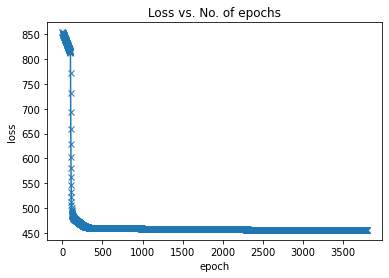

In [59]:
history = [{'val_loss': 853.8328857421875}] + history1 + history2 + history3 + history4 + history5 + history6 + history7
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

In [60]:
torch.save(model.state_dict() , 'insurance-huberloss.pth')

In [61]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[292.0662, -58.9106, -99.7943, 195.6400, 179.0302]])),
             ('linear.bias', tensor([-53.4294]))])